In [16]:
from utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare

In [17]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"

In [18]:
df = get_match_data(base_url.format(season))
ws = get_winstreak(df)

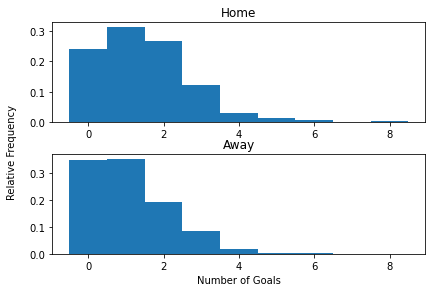

In [19]:
### Histogram of home and away goals
fig, axs = plt.subplots(2,1)
fig.text(0, .5, 'Relative Frequency', ha='center', va='center', rotation='vertical')
plt.xlabel("Number of Goals")
fig.tight_layout()
bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]
axs[0].hist(df["FTHG"], density=True,bins=bins)
axs[1].hist(df["FTAG"], density=True,bins=bins)
axs[0].set_title("Home")
axs[1].set_title("Away")

plt.savefig("figures/poisson_frequency.jpeg", dpi=300)

In [20]:
### Chi-sq goodness of fit test

### Home
home_mean = df.mean(axis=0)["FTHG"]
home_count = df["FTHG"].value_counts(sort=False) # 5 or more

home_count = [home_count[i] for i in range(5)]
home_count.append(380 - sum(home_count))
home_count = np.array(home_count)

home_expected = [poisson.pmf(i, home_mean) * 380 for i in range(5)]
home_expected.append(380 - sum(home_expected))
home_expected = np.array(home_expected)


### Away
away_mean = df.mean(axis=0)["FTAG"]
away_count = df["FTAG"].value_counts(sort=False) # 4 or more

away_count = [away_count[i] for i in range(4)]
away_count.append(380 - sum(away_count))
away_count = np.array(away_count)

away_expected = [poisson.pmf(i, away_mean) * 380 for i in range(4)]
away_expected.append(380 - sum(away_expected))
away_expected = np.array(away_expected)

### Test results:
print(chisquare(home_count,home_expected))
print(chisquare(away_count,away_expected))

Power_divergenceResult(statistic=3.9472231403120386, pvalue=0.5570393328345139)
Power_divergenceResult(statistic=1.1850001915376027, pvalue=0.8805620104086318)


In [24]:
### Gradient descent / NO MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
params = np.ones((4,20))

num_itrs = 10000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])


100%|██████████| 10000/10000 [00:18<00:00, 535.20it/s]


In [22]:
### Gradient descent / MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
team_params = np.ones((4,20))
streak_param = 1

num_itrs = 10000
lr = 0.00001

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]
        week = row["MatchWeek"]
        home_streak = ws.loc[week,row["HomeTeam"]]
        away_streak = ws.loc[week,row["AwayTeam"]]

        # update home team params
        team_params[0,home_index] += lr * (home_goal / team_params[0,home_index] - team_params[3,away_index] * (streak_param ** home_streak))
        team_params[1,home_index] += lr * (away_goal / team_params[1,home_index]// - team_params[2,away_index] * (streak_param ** away_streak))
        if home_streak != 0:
            streak_param += lr * (home_goal * home_streak / streak_param - home_streak * team_params[0,home_index] * team_params[3,away_index] * (streak_param ** (home_streak - 1)))

        # update away team params
        team_params[2,away_index] += lr * (away_goal / team_params[2,away_index] - team_params[1,home_index] * (streak_param ** away_streak))
        team_params[3,away_index] += lr * (home_goal / team_params[3,away_index] - team_params[0,home_index] * (streak_param ** home_streak))
        if away_streak != 0:
            streak_param += lr * (away_goal * away_streak / streak_param - away_streak * team_params[2,away_index] * team_params[1,home_index] * (streak_param ** (away_streak - 1)))


100%|██████████| 10000/10000 [00:39<00:00, 255.16it/s]


In [25]:
num_iters = 10

top4_count = np.zeros(20)
win_count = np.zeros(20)
bottom4_count = np.zeros(20)

sim = df.copy(deep=True)
sim["FTHG"] = np.nan
sim["FTAG"] = np.nan
sim["FTR"] = np.nan

for i in tqdm(range(num_iters)):
    standings = get_fast_standings(simulate_league(sim, params, teams_ind))
    for team in get_top4(standings):
        top4_count[teams_ind[team]] += 1
    for team in get_bottom4(standings):
        bottom4_count[teams_ind[team]] += 1
    win_count[teams_ind[get_winner(standings)[1]]] += 1



100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

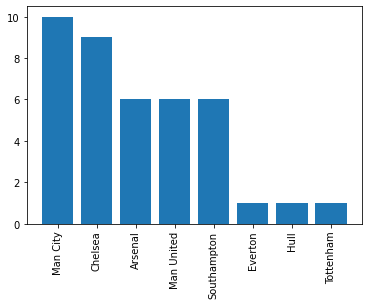

In [66]:
### Top 4 finishers

top4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), top4_count]).T, columns = ["Team", "Count"])
top4 = top4.astype({"Count": float})
top4 = top4.loc[top4["Count"] >= 1]
top4 = top4.sort_values(by="Count", ascending=False)

plt.bar(top4["Team"], top4["Count"])
plt.xticks(rotation="vertical");

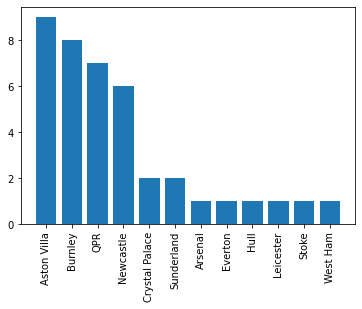

In [68]:
### Bottom 4 finishers

bottom4 = pd.DataFrame(data=np.array([list(teams_ind.keys()), bottom4_count]).T, columns = ["Team", "Count"])
bottom4 = bottom4.astype({"Count": float})
bottom4 = bottom4.loc[bottom4["Count"] >= 1]
bottom4 = bottom4.sort_values(by="Count", ascending=False)

plt.bar(bottom4["Team"], bottom4["Count"])
plt.xticks(rotation="vertical");

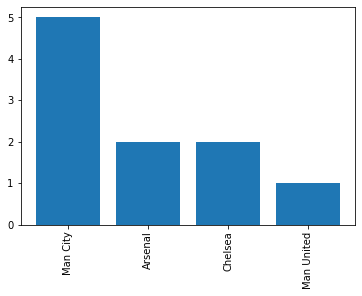

In [69]:
### League winners

winners = pd.DataFrame(data=np.array([list(teams_ind.keys()), win_count]).T, columns = ["Team", "Count"])
winners = winners.astype({"Count": float})
winners = winners.loc[winners["Count"] >= 1]
winners = winners.sort_values(by="Count", ascending=False)

plt.bar(winners["Team"], winners["Count"])
plt.xticks(rotation="vertical");